In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb
import shap

In [66]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness, get_distinctness_from_nearest_5, aggregate_embeddings_visual_and_language
from utils.utils_funcs import load_data_to_dict

In [67]:
def combine_nouns_and_verbs(struct1,struct2):
    words_full=list()
    embeds_full=dict()
    for w in struct1["embeds"]:
        ww=w+"_n"
        temp=dict()
        temp["visual"]=struct1["embeds"][w]["visual"]
        temp["language"]=struct1["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    for w in struct2["embeds"]:
        ww=w+"_v"
        temp=dict()
        temp["visual"]=struct2["embeds"][w]["visual"]
        temp["language"]=struct2["embeds"][w]["language"]
        embeds_full[ww]=temp
        words_full.append(ww)
    data_full=dict(
        embeds=embeds_full,
        words=words_full
    )
    return data_full

In [68]:
def get_concept_level_alignment_strength(struct,concepts,targets):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    sim_z_0=cosine_similarity(z_0)
    sim_z_1=cosine_similarity(z_1)
    rt=list()
    for target in targets:
        idx=concepts.index(target)
        aln=spearmanr(sim_z_0[idx],sim_z_1[idx])[0]
        if aln>0:
            rt.append(aln)
        else:
            rt.append(0)
    return rt

In [69]:
def combine_all_data(data,aoa_dict,v_var_dict,l_var_dict,v_dist_dict,l_dist_dict,freq_dict):
    aoas=list()
    v_vars=list()
    l_vars=list()
    v_dists=list()
    l_dists=list()
    freqs=list()
    
    intersect_concepts=list()
    for concept in aoa_dict:
        if concept not in freq_dict:
            print(concept)
        elif concept in data['words']:
            aoas.append(aoa_dict[concept])
            v_vars.append(v_var_dict[concept])
            l_vars.append(l_var_dict[concept])
            v_dists.append(v_dist_dict[concept])
            l_dists.append(l_dist_dict[concept])
            freqs.append(freq_dict[concept])
            intersect_concepts.append(concept)
    alignments=get_concept_level_alignment_strength(data,data['words'],intersect_concepts)
    return aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs

-----

In [70]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_swav_bert_window5_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_swav_bert_window5_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [71]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_ll_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_ll_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [72]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [73]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_glove_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_glove_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,1)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,1)

In [74]:
vg_all_data=combine_nouns_and_verbs(vg_noun_data,vg_verb_data)
aggregated_vg_all_data=aggregate_embeddings_visual_and_language(vg_all_data,20,20)

----

In [75]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [76]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [77]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [78]:
all_aoa_dict=dict()
for w in noun_aoa_dict:
    ww=w+"_n"
    all_aoa_dict[ww]=noun_aoa_dict[w]
for w in verb_aoa_dict:
    ww=w+"_v"
    all_aoa_dict[ww]=verb_aoa_dict[w]

----

In [79]:
noun_freq_dict=load_data_to_dict("../data/processed/childes_noun_freq.txt",header=True)
verb_freq_dict=load_data_to_dict("../data/processed/childes_verb_freq.txt",header=True)

In [80]:
all_freq_dict=dict()
for w in noun_freq_dict:
    ww=w+"_n"
    all_freq_dict[ww]=noun_freq_dict[w]
for w in verb_freq_dict:
    ww=w+"_v"
    all_freq_dict[ww]=verb_freq_dict[w]

----

## nouns+verbs

In [81]:
all_visual_variability,all_language_variability=get_variance(vg_all_data)

In [82]:
all_visual_discriminability,all_language_discriminability=get_distinctness_from_nearest_5(vg_all_data)

----

In [83]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_all_data,
                                                                     all_aoa_dict,
                                                                     all_visual_variability,
                                                                     all_language_variability,
                                                                     all_visual_discriminability,
                                                                     all_language_discriminability,
                                                                     all_freq_dict)

ballplayer_n
barroom_n
snowboard_n
abscond_v
affix_v
beckon_v
blacken_v
descend_v
emerge_v
gesticulate_v
install_v
necessitate_v
originate_v
overcharge_v
postpone_v
suspend_v
traverse_v
whiten_v


In [84]:
df=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability','frequency'])
# df1['type']='noun'

In [85]:
# df

In [86]:
# df['type']=df['type'].astype("category")

In [87]:
# df.dtypes

### Xgboost

In [88]:
x=df.iloc[:,1:]

In [89]:
y=df.iloc[:,:1]

In [90]:
# # Shuffling the data
# X_shuffle, y_shuffle = shuffle(x, y)

In [91]:
# xgb_rg = xgb.XGBRegressor(max_depth=3, n_estimators=100,
#                             objective ='reg:linear', booster='gbtree',
#                             n_jobs=2)

# # Cross-validation with 10 folds
# mse = cross_val_score(xgb_rg, X_shuffle, y_shuffle,
#                          scoring='neg_mean_squared_error',
#                          cv=10, n_jobs=-1)

# print("MSE Values: ", -1 * np.round(mse, 2))
# print("Average MSE: ", -1 * np.mean(mse))

In [92]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [93]:
# xgb_full= xgb.DMatrix(x, label=y)
# xgb_train = xgb.DMatrix(X_train, label=y_train)
# xgb_test = xgb.DMatrix(X_test, label=y_test)

In [94]:
# params = {
#     "eta": 0.002,
#     "max_depth": 5,
#     "subsample": 0.5
# }
# model_train = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

In [95]:
# explainer = shap.Explainer(model_train)
# shap_values = explainer(xgb_full)
# shap.plots.bar(shap_values)

In [96]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10, tree_method="hist", enable_categorical=True)
xg_reg = xgb.XGBRegressor(max_depth=6,subsample=0.5,n_estimators=10000,learning_rate=0.002)

In [97]:
model=xg_reg.fit(X_train,y_train)

In [98]:
preds = xg_reg.predict(X_test)

In [99]:
r=pearsonr(np.array(y_test).squeeze(),np.array(preds))[0]
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Pearson correlation: %f" % (r))
print("RMSE: %f" % (rmse))

Pearson correlation: 0.804069
RMSE: 1.274816


In [100]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [101]:
# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

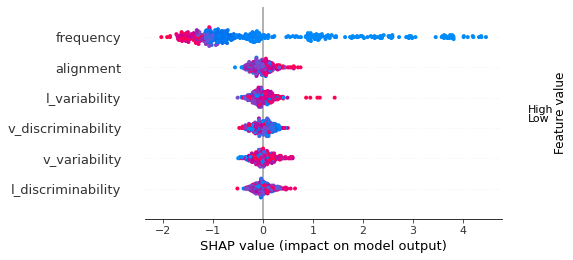

In [102]:
shap.summary_plot(shap_values, x)

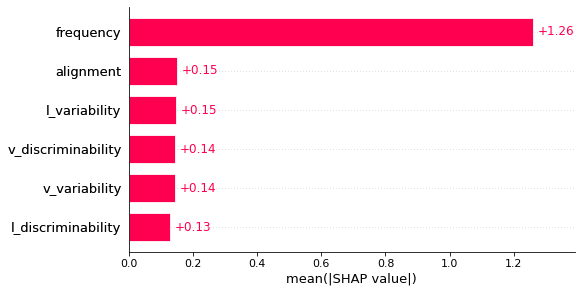

In [103]:
shap.plots.bar(shap_values)

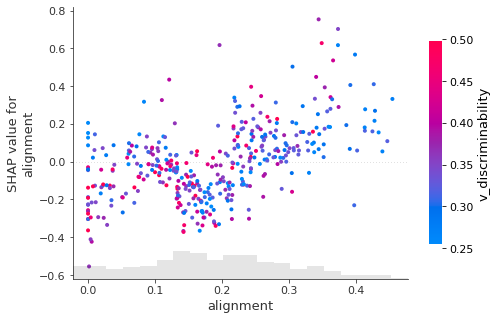

In [104]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"alignment"], color=shap_values)

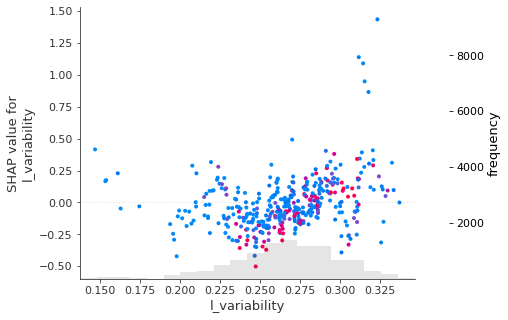

In [105]:
shap.plots.scatter(shap_values[:,"l_variability"], color=shap_values)

### Linear Regression

In [106]:
# results = smf.ols(formula = 'aoa ~ alignment+v_variability+l_variability+v_discriminability+l_discriminability',data=df).fit()

In [107]:
# results.summary()

## nouns and verbs respectively

In [108]:
noun_visual_variability,noun_language_variability=get_variance(vg_noun_data)
verb_visual_variability,verb_language_variability=get_variance(vg_verb_data)

In [109]:
noun_visual_discriminability,noun_language_discriminability=get_distinctness_from_nearest_5(vg_noun_data)
verb_visual_discriminability,verb_language_discriminability=get_distinctness_from_nearest_5(vg_verb_data)

In [110]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_noun_data,noun_aoa_dict,
                                                              noun_visual_variability,noun_language_variability,
                                                              noun_visual_discriminability,noun_language_discriminability,
                                                                    noun_freq_dict)

ballplayer
barroom
snowboard


In [111]:
df1=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability','frequency'])
# df1['type']='noun'

In [112]:
# df1

In [113]:
aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs=combine_all_data(aggregated_vg_verb_data,verb_aoa_dict,
                                                              verb_visual_variability,verb_language_variability,
                                                              verb_visual_discriminability,verb_language_discriminability,
                                                                    verb_freq_dict)

abscond
affix
beckon
blacken
descend
emerge
gesticulate
install
necessitate
originate
overcharge
postpone
suspend
traverse
whiten


In [114]:
df2=pd.DataFrame(data=np.transpose(np.array([aoas,alignments,v_vars,l_vars,v_dists,l_dists,freqs])),columns=['aoa','alignment','v_variability','l_variability','v_discriminability','l_discriminability','frequency'])
# df2['type']='verb'

In [115]:
# df2

In [116]:
df=pd.concat([df1,df2])

In [117]:
# df

In [118]:
# df['type']=df['type'].astype("category")

In [119]:
# df.dtypes

### Xgboost

In [120]:
x=df.iloc[:,1:]

In [121]:
y=df.iloc[:,:1]

In [122]:
# # Shuffling the data
# X_shuffle, y_shuffle = shuffle(x, y)

In [123]:
# xgb_rg = xgb.XGBRegressor(max_depth=3, n_estimators=100,
#                             objective ='reg:linear', booster='gbtree',
#                             n_jobs=2)

# # Cross-validation with 10 folds
# mse = cross_val_score(xgb_rg, X_shuffle, y_shuffle,
#                          scoring='neg_mean_squared_error',
#                          cv=10, n_jobs=-1)

# print("MSE Values: ", -1 * np.round(mse, 2))
# print("Average MSE: ", -1 * np.mean(mse))

In [124]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [125]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10, tree_method="hist", enable_categorical=True)
xg_reg = xgb.XGBRegressor(max_depth=6,subsample=0.5,n_estimators=10000,learning_rate=0.002)

In [126]:
model=xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [127]:
r=pearsonr(np.array(y_test).squeeze(),np.array(preds))[0]
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Pearson correlation: %f" % (r))
print("RMSE: %f" % (rmse))

Pearson correlation: 0.786631
RMSE: 1.063085


In [128]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [129]:
# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

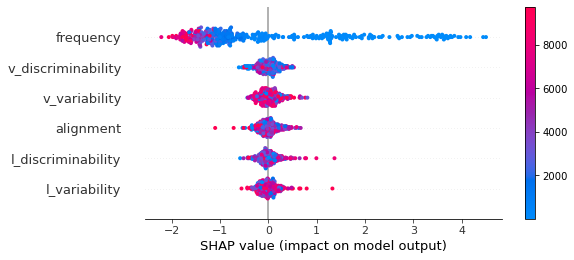

In [130]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, show=False, color_bar=False)
plt.colorbar()
plt.show()

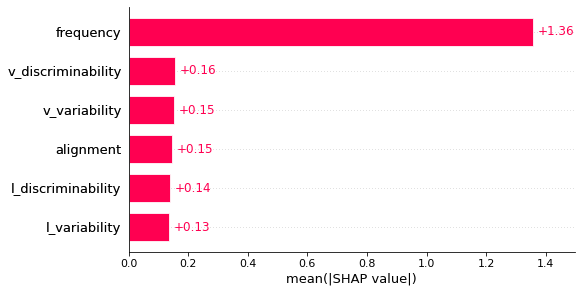

In [131]:
shap.plots.bar(shap_values)

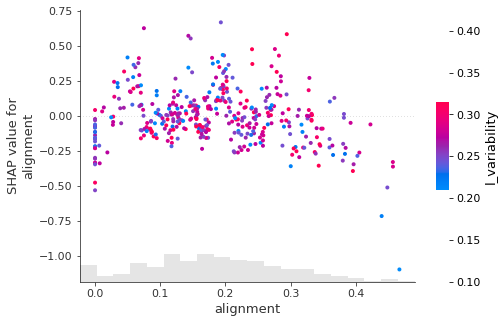

In [132]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"alignment"], color=shap_values)

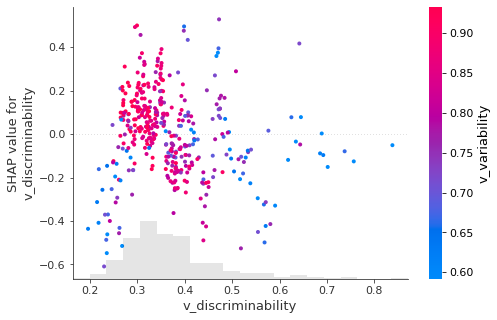

In [133]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"v_discriminability"], color=shap_values)

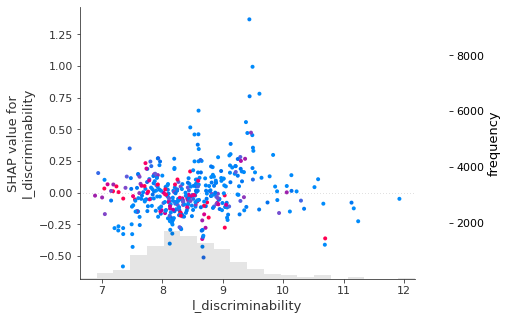

In [134]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"l_discriminability"], color=shap_values)

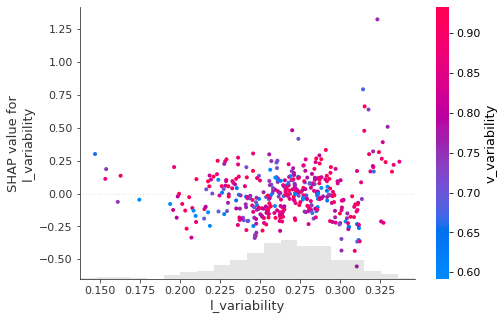

In [135]:
shap.plots.scatter(shap_values[:,"l_variability"], color=shap_values)

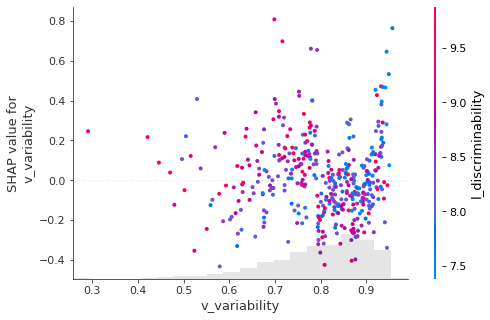

In [136]:
shap.plots.scatter(shap_values[:,"v_variability"], color=shap_values)

### Linear Regression

In [137]:
# results = smf.ols(formula = 'aoa ~ alignment+v_variability+l_variability+v_discriminability+l_discriminability',data=df).fit()

In [138]:
# results.summary()